<a href="https://colab.research.google.com/github/Reaper-ai/ML_AI/blob/main/02_Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
print("setup complete")

setup complete


In [98]:
print("Is CUDA available? ", torch.cuda.is_available())
print("Current device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Is CUDA available?  True
Current device: cuda


In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
# Load Data
data_train = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())
data_test = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=transforms.ToTensor())


In [101]:
class_names = data_train.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Label: Ankle boot


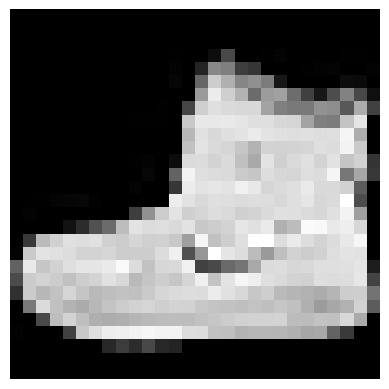

In [102]:
# Sample Image

image, label = data_train[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off")
print(f"Label: {class_names[label]}")

In [103]:
# Prepare data
batch_size = 64

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)


In [104]:
# Make model
class SimpleCNN(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=input_size,
                  out_channels=16,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=16,
                  out_channels=16,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16,
                  out_channels=16,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=16,
                  out_channels=16,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    self.out_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=16*7*7,
                  out_features=10)
    )


  def forward(self, x):
    logits = nn.Sequential(
        self.conv_layer1,
        self.conv_layer2,
        self.out_layer
    )(x)
    return logits



cnn_net = SimpleCNN(1)
my_model = cnn_net.to(device)

In [105]:
# Set up loss fn and optimizer

loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(my_model.parameters(), lr=0.004)
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)

In [106]:
def train_loop(model, train_loader, loss_fn, optimizer):

  model.train()

  for batch, (X,y) in enumerate(train_loader):

    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [107]:
def test_loop(model, test_loader, loss_fn):
  model.eval()
  size = len(test_loader.dataset)
  num_batches = len(test_loader)
  test_loss, correct = 0, 0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_loader):

      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      correct += (test_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return correct, test_loss



In [108]:
# Train and evaluate model

epochs = 20
for t in range(1,epochs+1):
    train_loop(my_model,train_loader, loss_fn, optimizer)
    correct, test_loss = test_loop(my_model, test_loader,loss_fn, )


    print(f"Epoch {t}\n-------------------------------")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.413272 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.335488 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.305519 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.297537 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.277747 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.266851 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 90.9%, Avg loss: 0.258785 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 90.9%, Avg loss: 0.250699 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 91.2%, Avg loss: 0.252058 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 91.3%, Avg loss: 0.245340 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 91.4%, Avg los

In [109]:
# Take random samples for plotting

import random
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(data_test), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [110]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)

            # Get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [111]:
pred_probs= make_predictions(model=my_model,
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)


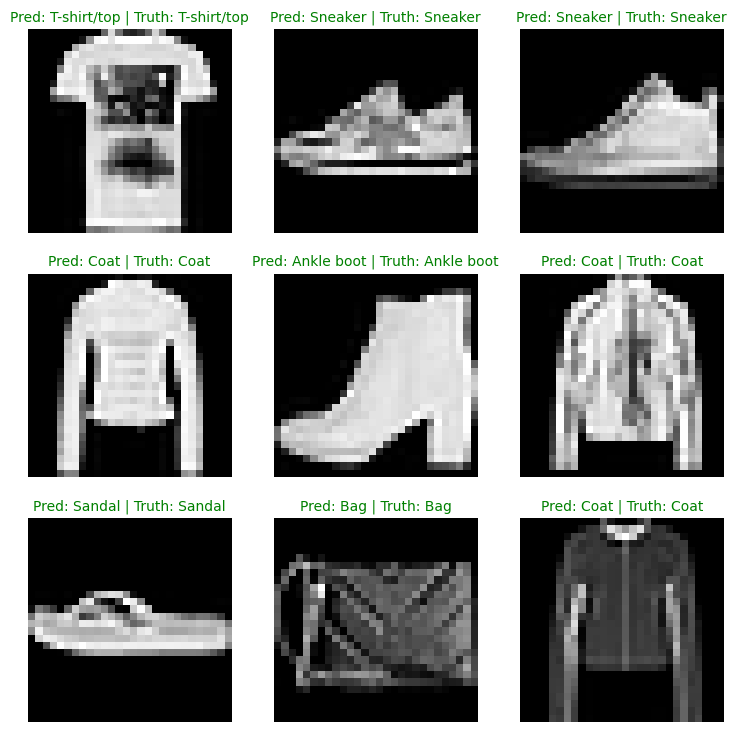

In [112]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)


  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [113]:
# Confusion Matrix
y_preds = []
y_true = []
my_model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_logits = my_model(X)
        y_pred = y_logits.argmax(dim=1)
        y_preds.append(y_pred.cpu())
        y_true.append(y.cpu())

# Combine predictions
y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)


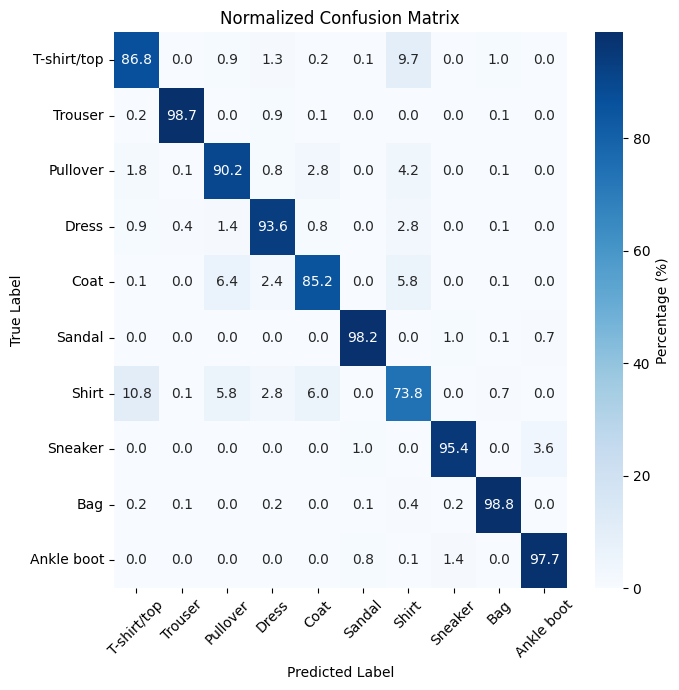

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Convert to numpy arrays if needed
y_true_np = y_true.numpy()
y_pred_np = y_preds.numpy()

# Create raw confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np)

# Normalize
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(7, 7))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage (%)'})

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
